# Mod 4 Project - Starter Notebook

## Step 1 - Import necessary packages and Zillow data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
from fbprophet import Prophet as proph
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.plotting.register_matplotlib_converters()

In [3]:
df = pd.read_csv('zillow_data.csv')

In [4]:
# Preview the data
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


## Step 2: Data Preprocessing

In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [7]:
avg_df = melt_data(df)

In [8]:
avg_df.index = pd.to_datetime(avg_df.index)

### Plotting the National Average per Month

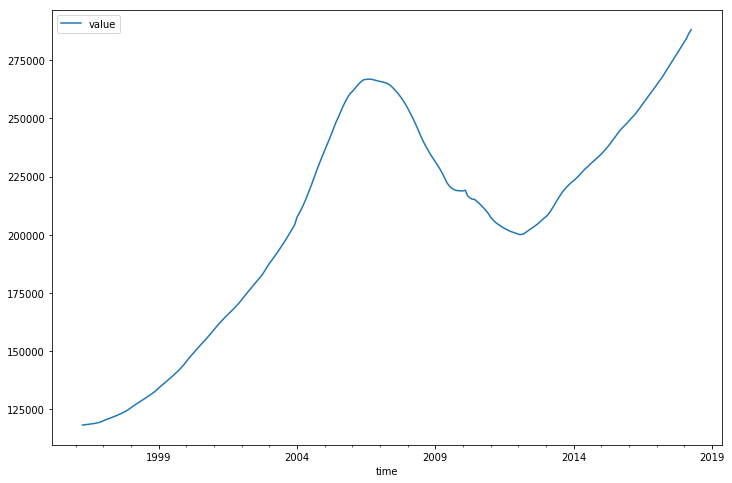

In [9]:
avg_df.plot(kind = 'line', figsize= (12,8))
plt.show()

2008 House Market Crash

## Step 3 - NY Average vs National Average

First we want to melt so that we can change the format from Wide Format to Long Format

In [10]:
df_melt = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'])
df_melt = df_melt.drop(['RegionID'], axis=1)
df_melt = df_melt.rename(columns={'variable':'time'})

Filter the data to NY only

In [11]:
state_df = df_melt[df_melt['State'] == 'NY'].iloc[:,6:]
state_df = state_df.groupby('time').mean()
state_df.index = pd.to_datetime(state_df.index)

MinMax Transformation to scale the NY average data appropriately to the National average data.

In [12]:
state_minmax = (state_df['value'] - min(state_df['value']))/(max(state_df['value']) - min(state_df['value']))

In [13]:
# Preview the MinMax Transformation
state_minmax.head()

time
1996-04-01    0.001457
1996-05-01    0.001154
1996-06-01    0.000862
1996-07-01    0.000540
1996-08-01    0.000262
Name: value, dtype: float64

#### State_check function will allow us to view each user-inputted state average against the national average.

In [14]:
def state_check(state):
    state_df = df_melt[df_melt['State'] == state].iloc[:,6:]
    state_df = state_df.groupby('time').mean()
    state_df.index = pd.to_datetime(state_df.index)

    state_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{state} Average per Month")
    plt.show()
    
    print(f"Avg Low Price: ${round(state_df['value'].min(),0)}")
    print(f"Avg High Price: ${round(state_df['value'].max(),0)}")
    
    state_minmax = (state_df['value'] - min(state_df['value']))/(max(state_df['value']) - min(state_df['value']))    
    avg_minmax = (avg_df['value'] - min(avg_df['value']))/(max(avg_df['value']) - min(avg_df['value']))

    fig = plt.figure(figsize=(12,8))
    current = plt.plot(state_minmax, color='blue', label=f"{state} Avg")
    avg = plt.plot(avg_minmax, color='red', label='National Avg')
    plt.legend(loc='best')
    plt.title(f'{state} Average vs National Average')
    plt.show()

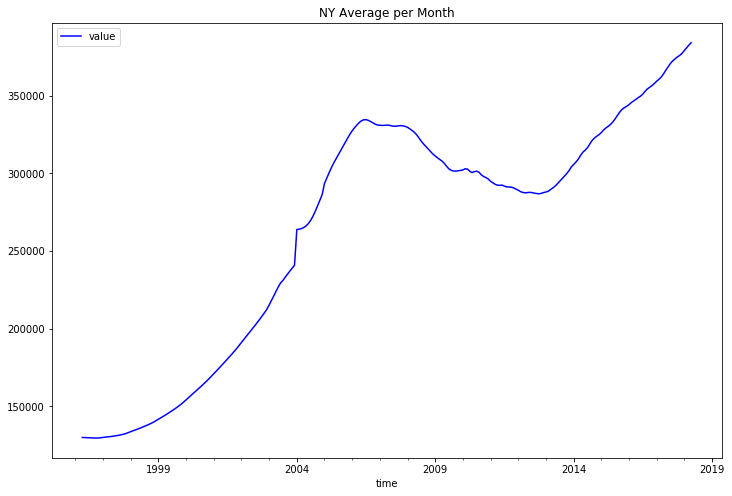

Avg Low Price: $129557.0
Avg High Price: $384161.0


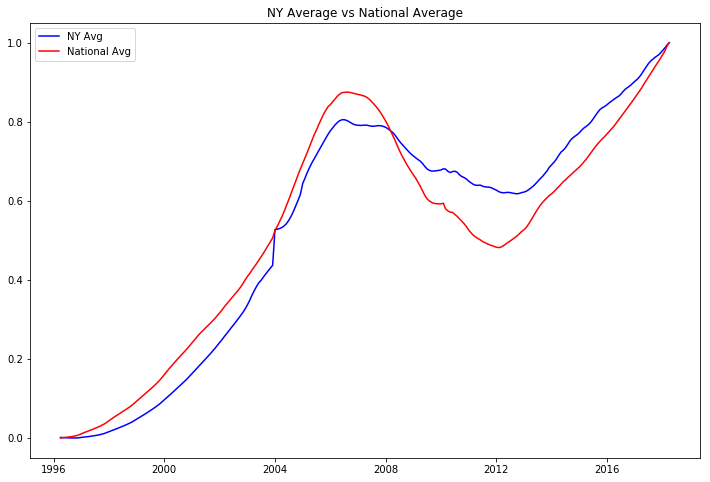

In [15]:
state_check("NY")

Because NY is the finance capital of the world, we will move forward with NY.<br>
And also because I'm a resident of NY.

## Step 4 - City Averages vs NY State Average

Same idea as above, we want to format the data to NY State.

In [16]:
ny_df = df_melt[df_melt["State"] == "NY"]
ny_avg_df = ny_df[['time','value']].groupby('time').mean()

Aggregating the data to city, month and averaging the house prices.

In [17]:
ny_metro_df = ny_df[['Metro','time','value']].groupby(['Metro','time']).mean()
ny_metro_df = ny_metro_df.reset_index()
ny_metro_df = ny_metro_df.set_index('time')
ny_metro_df.index = pd.to_datetime(ny_metro_df.index)
ny_metro_df = ny_metro_df.reset_index()

#### Plotting all NY Cities against each other

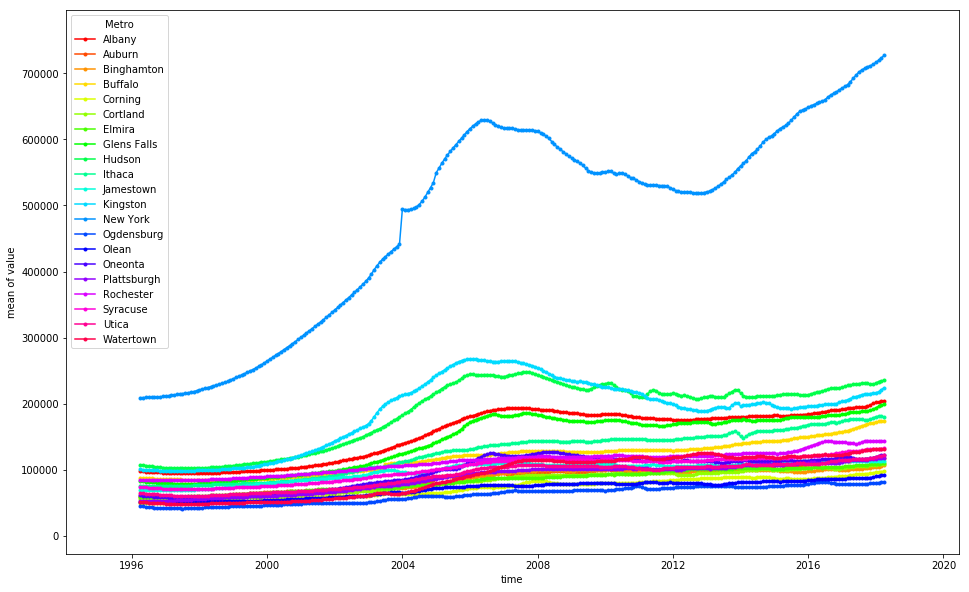

In [18]:
fig = interaction_plot(ny_metro_df['time'],ny_metro_df['Metro'],ny_metro_df['value'])
fig.set_size_inches(16,10)
plt.show()

We can see that average house value of New York City is way higher than all other cities.<br>
Let's try MinMax Scaling the data to compare trends.

In [19]:
ny_metro_df = ny_df[['Metro','time','value']].groupby(['Metro','time']).mean()
ny_metro_df = ny_metro_df.reset_index()
ny_metro_df = ny_metro_df.set_index('time')

metro_minmax = []
for x in ny_metro_df['Metro'].unique():
    a = ny_metro_df[ny_metro_df['Metro'] == x]
    b = (a['value'] - min(a['value']))/(max(a['value']) - min(a['value']))
    metro_minmax.append(b)

metro_minmax = pd.DataFrame(metro_minmax)
metro_minmax['Metro'] = ['Albany','Auburn','Binghamton','Buffalo','Corning','Cortland','Elmira',
                        'Glens Falls','Hudson','Ithaca','Jamestown','Kingston','New York',
                        'Ogdensburg','Olean','Oneonta','Plattsburgh','Rochester','Syracuse',
                        'Utica','Watertown']
metro_minmax = pd.melt(metro_minmax, id_vars=['Metro'])

#### MinMax Transformed NY city data plot

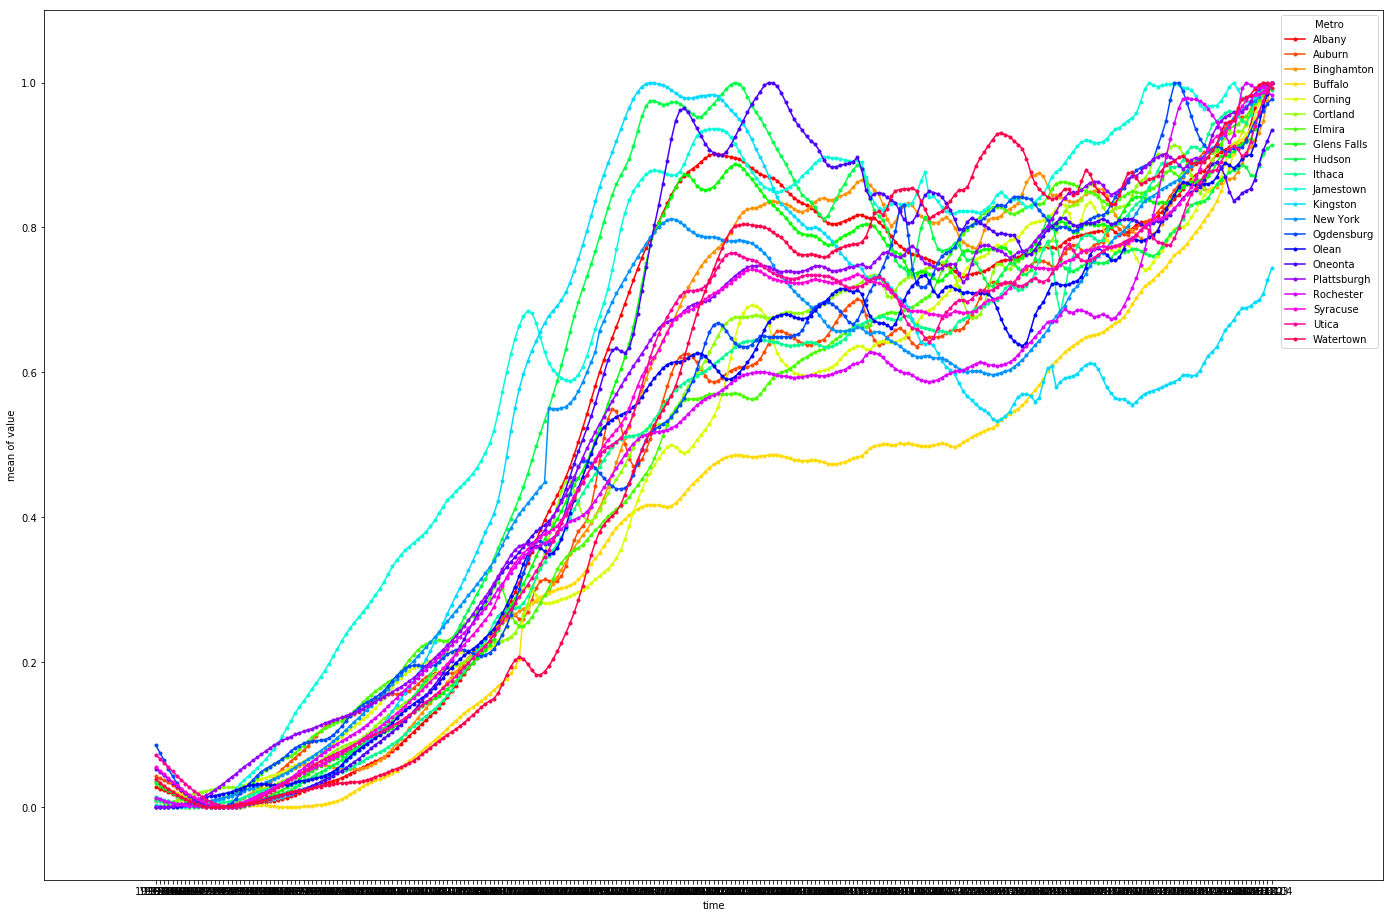

In [20]:
fig = interaction_plot(metro_minmax['time'],metro_minmax['Metro'],metro_minmax['value'])
fig.set_size_inches(24,16)
plt.show()

This graph is very congested and difficult to view. <br>
What stands out to me is it all generally follows the 2008 House Market Crash but not as sharply as the national average.

#### Metro_check function will compare each user-inputted NY city average to the NY state average.

In [21]:
def metro_check(metro):
    metro_df = ny_df[ny_df['Metro'] == metro].iloc[:,6:]
    metro_df = metro_df.groupby('time').mean()
    metro_df.index = pd.to_datetime(metro_df.index)

    metro_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{metro} Average per Month")
    plt.show()
    print(f"Avg Low Price: ${round(metro_df['value'].min(),0)}")
    print(f"Avg High Price: ${round(metro_df['value'].max(),0)}")
    
    ny_avg_df = ny_df[['time','value']].groupby('time').mean()
    ny_avg_df.index = pd.to_datetime(ny_avg_df.index)
    
    metro_minmax = (metro_df['value'] - min(metro_df['value']))/(max(metro_df['value']) - min(metro_df['value']))
    ny_minmax = (ny_avg_df['value'] - min(ny_avg_df['value']))/(max(ny_avg_df['value']) - min(ny_avg_df['value']))

    fig = plt.figure(figsize=(12,8))
    ny = plt.plot(ny_minmax, color='red', label='NY Avg')
    current = plt.plot(metro_minmax, color='blue', label=f"{metro} Avg")
    plt.legend(loc='best')
    plt.title(f'{metro} Average vs New York Average')
    plt.show()

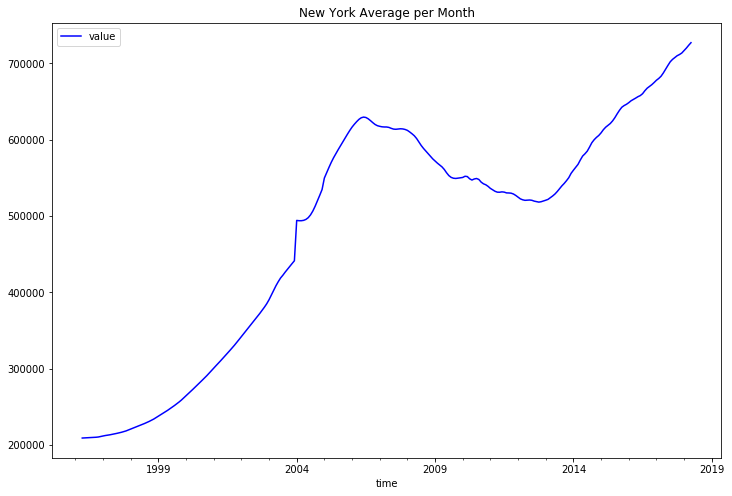

Avg Low Price: $209129.0
Avg High Price: $726948.0


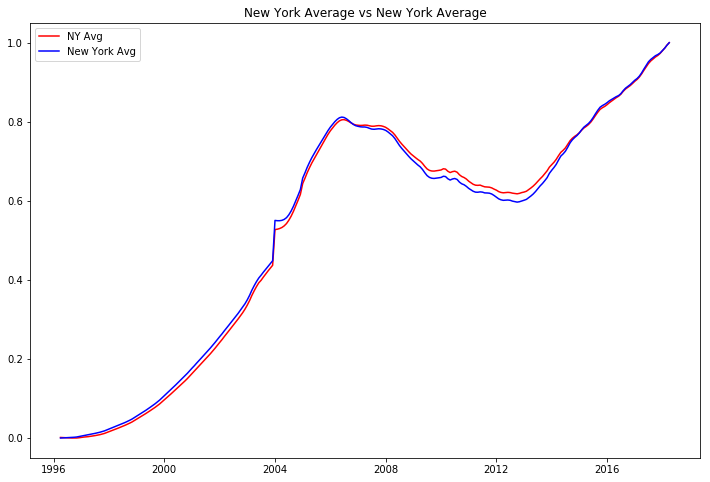

In [22]:
metro_check("New York")

NY City follows very closely to the NY State average. It makes sense because the NY State average is the average of each individual NY zip code. Reason I did it this way is because we are focusing on zip code data. <br><br>
We will move forward with New York City. Again, financial capital and I live here.

## Step 5 - Choose the top 3 forecasted NY Counties

Filtering the data for NY City and getting the average.

In [23]:
newyork_df = df_melt[(df_melt["State"] == "NY") & (df_melt["Metro"] == "New York")]
newyork_avg_df = newyork_df[['time','value']].groupby('time').mean()

In [24]:
newyork_county_df = newyork_df[['CountyName','time','value']].groupby(['CountyName','time']).mean()
newyork_county_df = newyork_county_df.reset_index()
newyork_county_df = newyork_county_df.set_index('time')
newyork_county_df.index = pd.to_datetime(newyork_county_df.index)
newyork_county_df = newyork_county_df.reset_index()

#### Plotting the NY Counties against each other

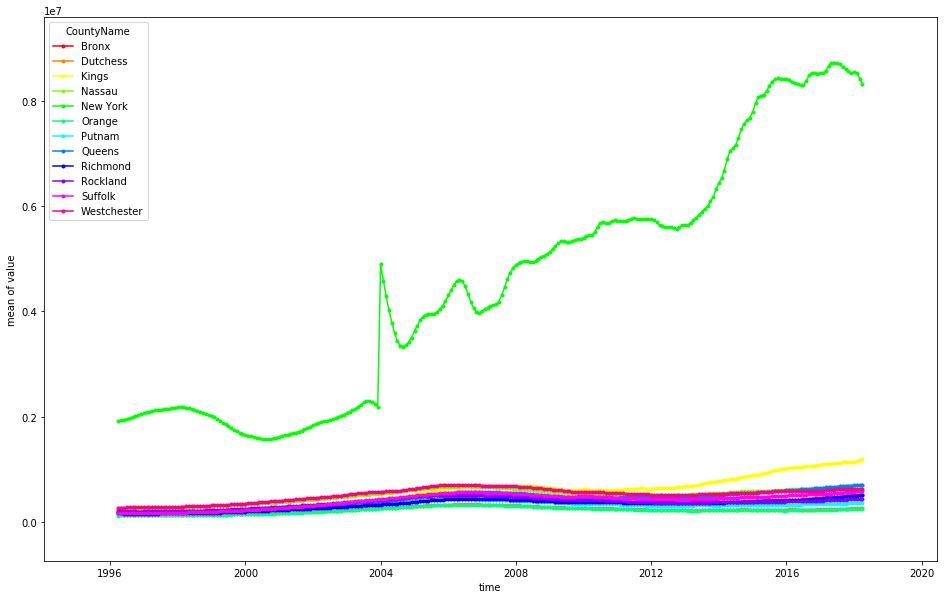

In [25]:
fig = interaction_plot(newyork_county_df['time'],newyork_county_df['CountyName'],newyork_county_df['value'])
fig.set_size_inches(16,10)
plt.show()

In terms of average house value, Manhattan is way higher than all other counties. <br>
By the way, 'New York' countyname = Manhattan.

MinMax Scaling the data

In [26]:
newyork_county_df = newyork_df[['CountyName','time','value']].groupby(['CountyName','time']).mean()
newyork_county_df = newyork_county_df.reset_index()
newyork_county_df = newyork_county_df.set_index('time')

county_minmax = []
for x in newyork_county_df['CountyName'].unique():
    a = newyork_county_df[newyork_county_df['CountyName'] == x]
    b = (a['value'] - min(a['value']))/(max(a['value']) - min(a['value']))
    county_minmax.append(b)

county_minmax = pd.DataFrame(county_minmax)
county_minmax['CountyName'] = ['Bronx','Dutchess','Kings','Nassau','New York','Orange','Putnam',
                        'Queens','Richmond','Rockland','Suffolk','Westchester']
county_minmax = pd.melt(county_minmax, id_vars=['CountyName'])

#### Plotting the MinMax Scaled County data against each other.

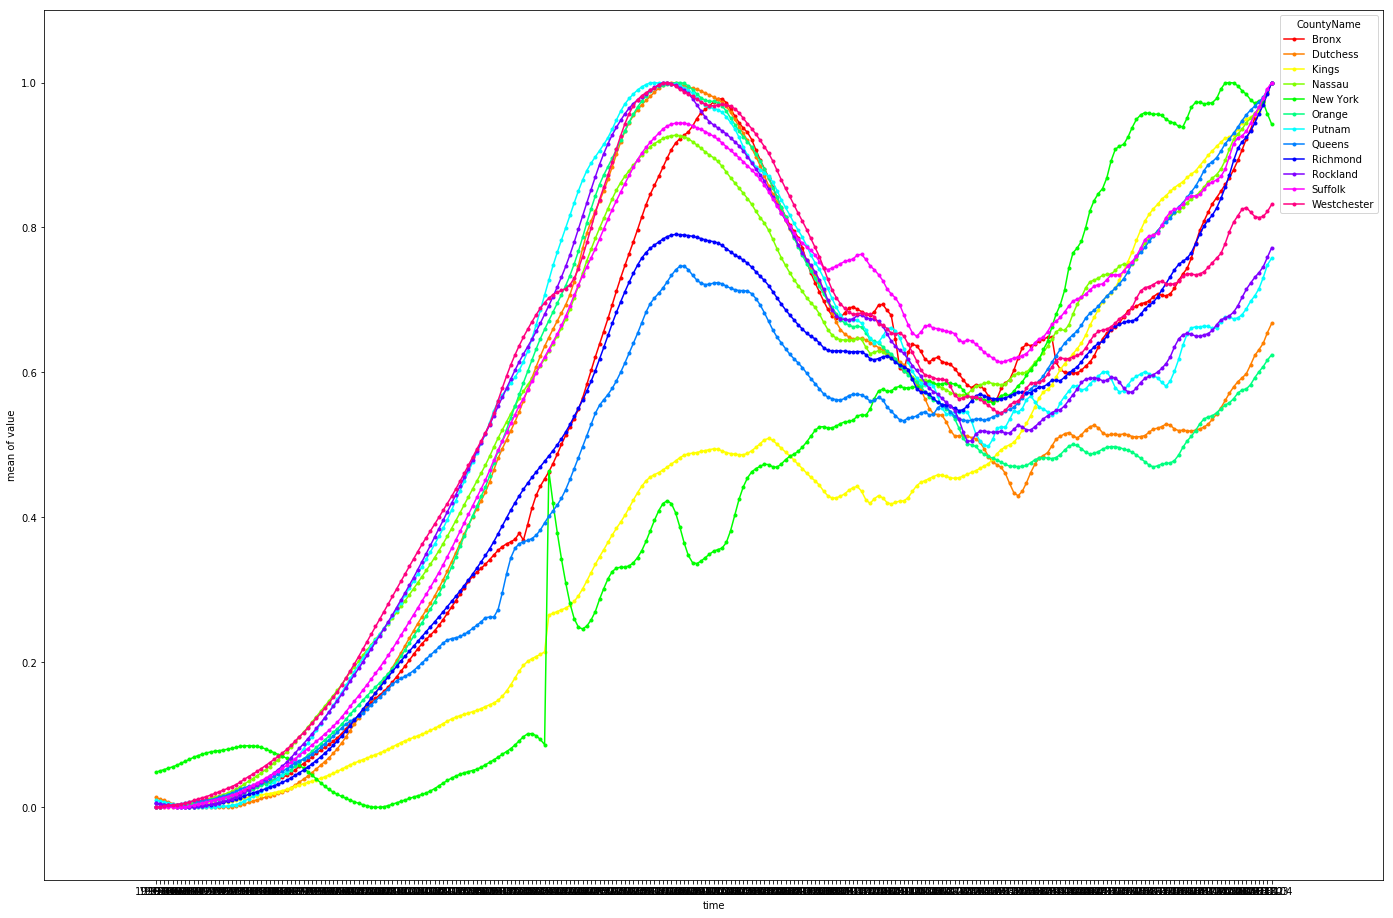

In [27]:
fig = interaction_plot(county_minmax['time'],county_minmax['CountyName'],county_minmax['value'])
fig.set_size_inches(24,16)
plt.show()

Plot above is a little congested. <br>
What stands out is Manhattan and Brooklyn houses did not crash nearly as bad during the 2008 house market crash.<br>
Dutchess and Orange counties crashed the most but not by a lot.<br>
By the way, 'Kings' countyname = Brooklyn.

#### County_check function will compare each user-inputted county average against the NY City average AND give us the county forecast 3 years into the future, 2021-04-01.
- Plot 1: NY County average house per month
- Plot 2: MinMaxScaled NY County vs MinMaxScaled NY City
- Plot 3: FB Prophet's tool, black datapoints is the true data. Blue line is the forecast average. Shaded blue is the forecast region
- Plot 4: Similar to plot 3, plots the yearly data including forecast.
- Plot 5: Plots the monthly average gain/loss.
- Bottom data: 2018-04-01 average house price. 2019, 2020, 2021 predictions. Potential % increase for each year.

In [28]:
def county_check(countyname):
    county_df = newyork_df[newyork_df['CountyName'] == countyname].iloc[:,6:]
    county_df = county_df.groupby('time').mean()
    county_df.index = pd.to_datetime(county_df.index)

    county_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{countyname} Average per Month")
    plt.show()
    
    newyork_avg_df = newyork_df[['time','value']].groupby('time').mean()
    newyork_avg_df.index = pd.to_datetime(newyork_avg_df.index)
    
    county_minmax = (county_df['value'] - min(county_df['value']))/(max(county_df['value']) - min(county_df['value']))
    newyork_minmax = (newyork_avg_df['value'] - min(newyork_avg_df['value']))/(max(newyork_avg_df['value']) - min(newyork_avg_df['value']))

    fig = plt.figure(figsize=(12,8))
    newyork = plt.plot(newyork_minmax, color='red', label='NY Avg')
    county = plt.plot(county_minmax, color='blue', label=f"{countyname} Avg")
    plt.legend(loc='best')
    plt.title(f'{countyname} Average vs New York Average')
    plt.show()
        
    county_prophet = county_df.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(county_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    
    Model.plot(forecast, uncertainty=True)
    plt.show()
    
    Model.plot_components(forecast)
    plt.show()
    
    county_df = county_df.reset_index()
    
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    last_true = round(county_df[county_df['time'] == '2018-04-01']['value'].max(),0)
    first_predict = forecast_important[(forecast_important['ds'] == '2019-04-01')]['yhat'].values
    second_predict = forecast_important[(forecast_important['ds'] == '2020-04-01')]['yhat'].values
    third_predict = forecast_important[(forecast_important['ds'] == '2021-04-01')]['yhat'].values
    
    print(f"2018-04-01: {last_true}")
    print("--------------------------------------------------------------")
    print(forecast_important[(forecast_important['ds'] == '2019-04-01') |
                   (forecast_important['ds'] == '2020-04-01') |
                   (forecast_important['ds'] == '2021-04-01')])
    print("--------------------------------------------------------------")
    print(f"% Increase 2019-04-01: {first_predict/last_true}")
    print(f"% Increase 2020-04-01: {second_predict/last_true}")
    print(f"% Increase 2021-04-01: {third_predict/last_true}")

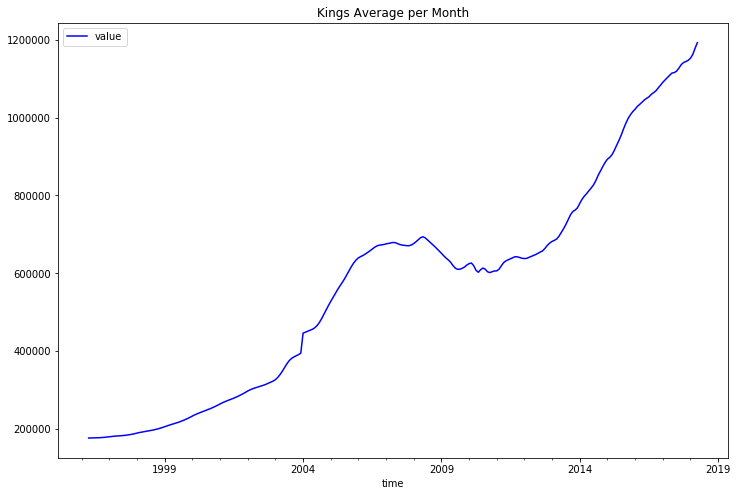

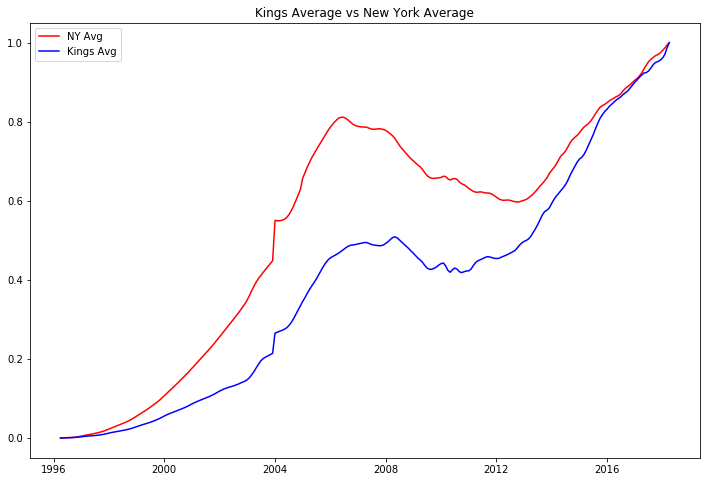

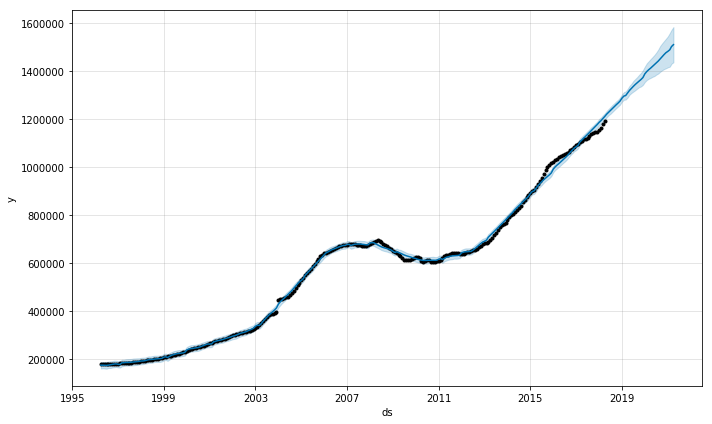

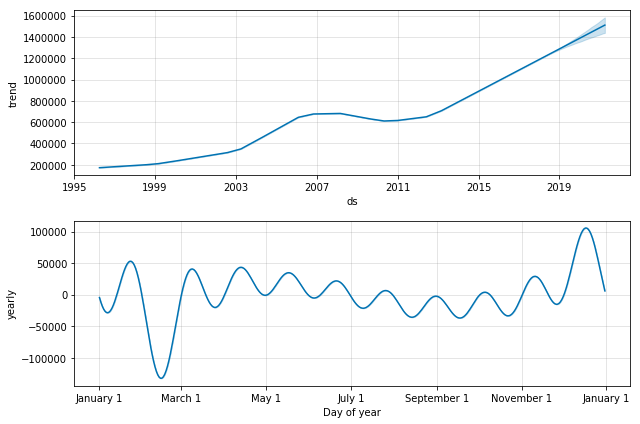

2018-04-01: 1192739.0
--------------------------------------------------------------
            ds          yhat    yhat_lower    yhat_upper
276 2019-04-01  1.308816e+06  1.289652e+06  1.325641e+06
288 2020-04-01  1.412185e+06  1.371500e+06  1.449844e+06
300 2021-04-01  1.510307e+06  1.436807e+06  1.583972e+06
--------------------------------------------------------------
% Increase 2019-04-01: [1.09731991]
% Increase 2020-04-01: [1.18398516]
% Increase 2021-04-01: [1.26625089]


In [29]:
county_check("Kings")

What we are looking for is the highest % increase from 2018-04 Zillow's data to the 2021-04 prediction.

#### Below code will gather all the NY counties' forecasted data and % increases into one neat dataframe.

In [30]:
county_predictions = pd.DataFrame(columns = ('CountyName','ds',
                                             'yhat','yhat % increase',
                                             'yhat_lower','yhat_lower % increase',
                                             'yhat_upper','yhat_upper % increase'))

for x in newyork_df['CountyName'].unique():
    county_1 = newyork_df[newyork_df['CountyName'] == x].iloc[:,6:]
    county_1 = county_1.groupby('time').mean()
    county_1.index = pd.to_datetime(county_1.index)
    
    county_prophet = county_1.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
    
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(county_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_important = forecast_important[(forecast_important['ds'] == '2019-04-01') |
                                        (forecast_important['ds'] == '2020-04-01') |
                                        (forecast_important['ds'] == '2021-04-01')]

    county_1 = county_1.reset_index()
    
    county_add = pd.DataFrame({
        'CountyName': x,
        'ds': forecast_important['ds'],
        'yhat': forecast_important['yhat'],
        'yhat % increase': round(forecast_important['yhat']/county_1[county_1['time'] =='2018-04']['value'].max(),3),
        'yhat_lower': forecast_important['yhat_lower'],
        'yhat_lower % increase': round(forecast_important['yhat_lower']/county_1[county_1['time'] =='2018-04']['value'].max(),3),
        'yhat_upper': forecast_important['yhat_upper'],
        'yhat_upper % increase': round(forecast_important['yhat_upper']/county_1[county_1['time'] =='2018-04']['value'].max(),3),
    })

    county_predictions = pd.concat([county_predictions, county_add])
    print(f"Added: {x}")

Added: Bronx
Added: Kings
Added: Queens
Added: New York
Added: Richmond
Added: Westchester
Added: Suffolk
Added: Orange
Added: Nassau
Added: Dutchess
Added: Rockland
Added: Putnam


Below dataframe is sorted descending by predicted % increase. This way we can see which county has the highest predicted increase.

In [31]:
county_predictions[county_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False)

,CountyName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,New York,2021-04-01,1.089223e+07,1.311,1.036807e+07,1.247,1.139520e+07,1.371
300,Kings,2021-04-01,1.510307e+06,1.266,1.426670e+06,1.196,1.584568e+06,1.329
300,Queens,2021-04-01,8.512373e+05,1.192,7.943057e+05,1.112,9.101795e+05,1.274
300,Richmond,2021-04-01,5.872607e+05,1.135,5.577232e+05,1.078,6.201757e+05,1.199
300,Suffolk,2021-04-01,6.690565e+05,1.127,6.207410e+05,1.046,7.112760e+05,1.198
300,Nassau,2021-04-01,8.028777e+05,1.127,7.381930e+05,1.036,8.601906e+05,1.207
300,Westchester,2021-04-01,7.047164e+05,1.107,6.382472e+05,1.003,7.656963e+05,1.203
300,Bronx,2021-04-01,5.811987e+05,1.106,5.326247e+05,1.013,6.282180e+05,1.195
300,Rockland,2021-04-01,4.743321e+05,1.057,4.368671e+05,0.974,5.151755e+05,1.148
300,Putnam,2021-04-01,3.888192e+05,1.042,3.526140e+05,0.945,4.205410e+05,1.127


1 - Manhattan <br>
2 - Brooklyn <br>
3 - Queens <br><br>
#### Moving on with these 3 counties...

## Step 6 - Zip Codes vs Manhattan, Brooklyn, Queens County
- We will tackle each county one by one.
- Find the top 3 zip codes for each county.
- Find the top 5 zip codes for all 3 counties together.

### Manhattan Zip Codes

Filtering the data to Manhattan county

In [32]:
newyorkcity_df = df_melt[df_melt["CountyName"] == "New York"]
newyorkcity_avg_df = newyorkcity_df[['time','value']].groupby('time').mean()

In [33]:
newyork_city_df = newyorkcity_df[['RegionName','time','value']].groupby(['RegionName','time']).mean()
newyork_city_df = newyork_city_df.reset_index()
newyork_city_df = newyork_city_df.set_index('time')
newyork_city_df.index = pd.to_datetime(newyork_city_df.index)
newyork_city_df = newyork_city_df.reset_index()

#### Plotting the Manhattan zip codes against each other.
- <i> note* There is missing data

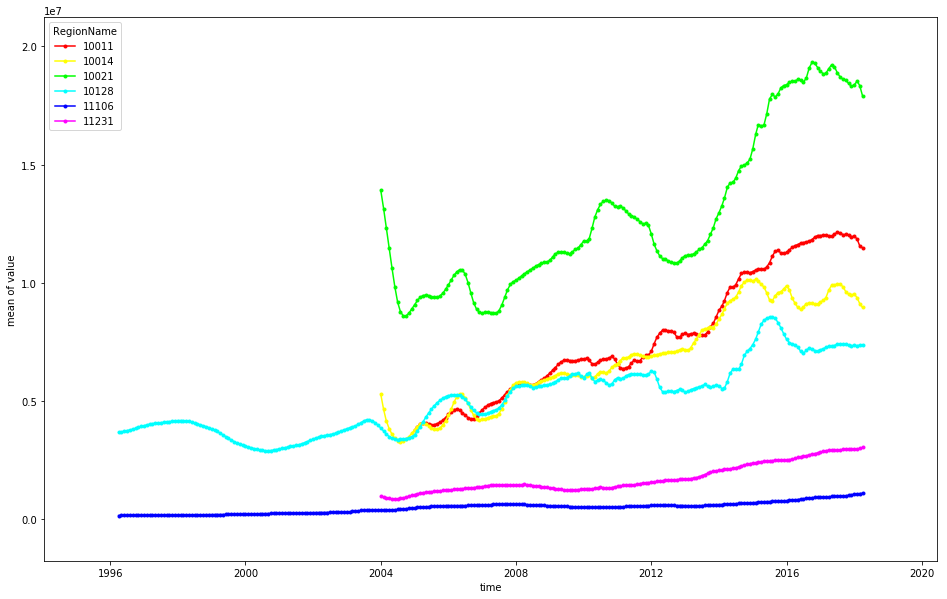

In [34]:
fig = interaction_plot(newyork_city_df['time'],newyork_city_df['RegionName'],newyork_city_df['value'])
fig.set_size_inches(16,10)
plt.show()

MinMax Scaling the Manhattan Zip Codes

In [35]:
newyork_city_df = newyorkcity_df[['RegionName','time','value']].groupby(['RegionName','time']).mean()
newyork_city_df = newyork_city_df.reset_index()
newyork_city_df = newyork_city_df.set_index('time')
newyork_city_df = newyork_city_df.fillna(method='bfill')

city_minmax = []
for x in newyork_city_df['RegionName'].unique():
    a = newyork_city_df[newyork_city_df['RegionName'] == x]
    b = (a['value'] - min(a['value']))/(max(a['value']) - min(a['value']))
    city_minmax.append(b)

city_minmax = pd.DataFrame(city_minmax)
city_minmax['RegionName'] = [10011, 10014, 10021, 10128, 11106, 11231]
city_minmax = pd.melt(city_minmax, id_vars=['RegionName'])

#### Plotting all the MinMax Scaled Zip Codes against each other.
- The straight horizontal line is missing data points that were backfilled.

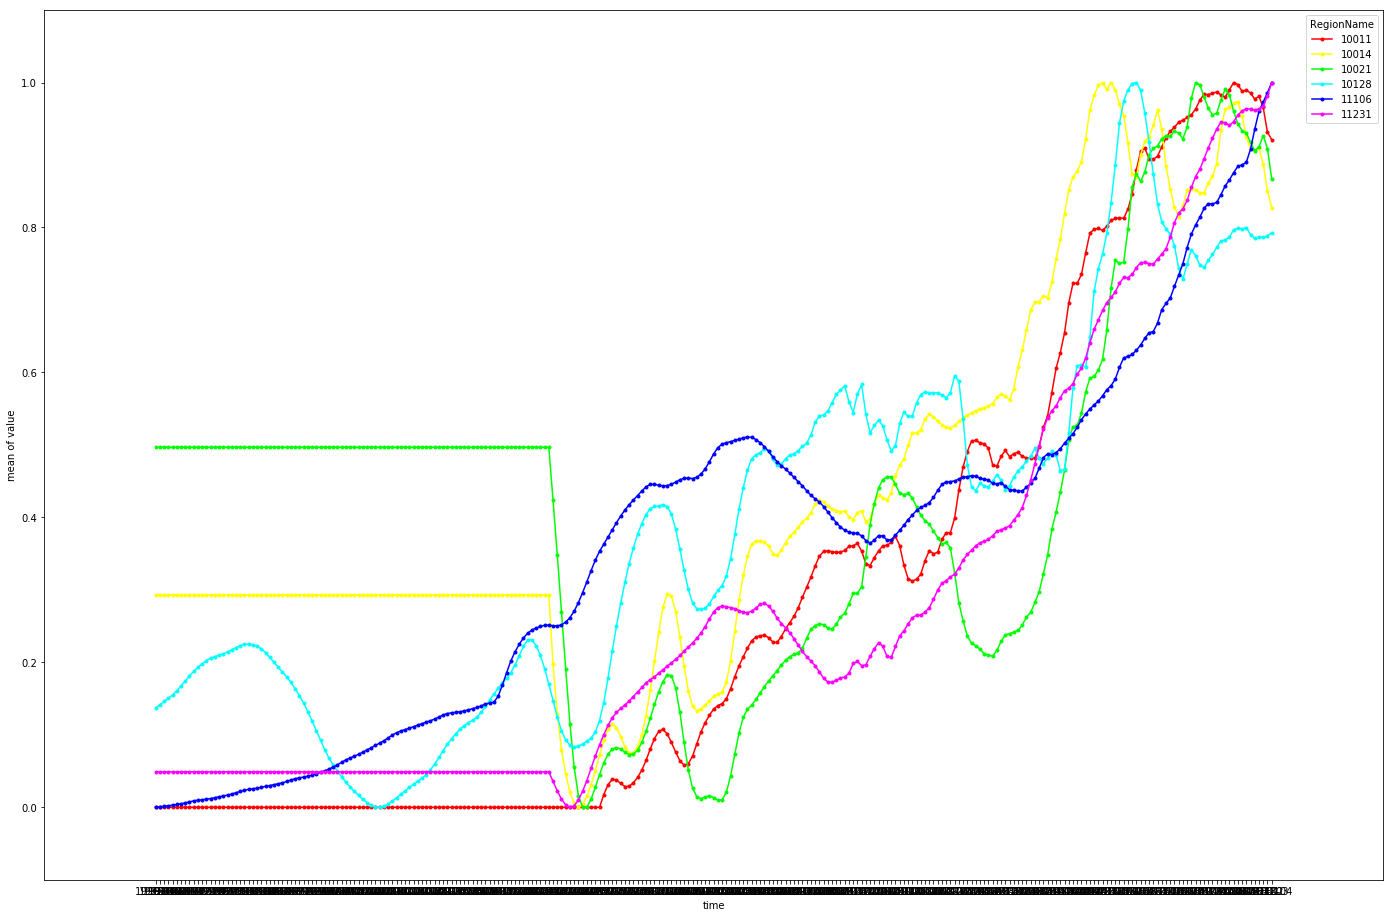

In [36]:
fig = interaction_plot(city_minmax['time'],city_minmax['RegionName'],city_minmax['value'])
fig.set_size_inches(24,16)
plt.show()

#### nyc_check function is very similar to county_check function. Compares user-inputted zip code against Manhattan average.

In [37]:
def nyc_check(zipcode):
    zip_df = newyorkcity_df[newyorkcity_df['RegionName'] == zipcode].iloc[:,6:]
    zip_df = zip_df.groupby('time').mean()
    zip_df.index = pd.to_datetime(zip_df.index)
    
    zip_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{zipcode} Average per Month")
    plt.show()
    
    newyorkcity_avg_df = newyorkcity_df[['time','value']].groupby('time').mean()
    newyorkcity_avg_df.index = pd.to_datetime(newyorkcity_avg_df.index)
    
    # No replacing NaN because it changes the predictions
    # zip_df = zip_df.fillna(method='bfill')
    
    zip_minmax = (zip_df['value'] - min(zip_df['value']))/(max(zip_df['value']) - min(zip_df['value']))
    newyorkcity_minmax = (newyorkcity_avg_df['value'] - min(newyorkcity_avg_df['value']))/(max(newyorkcity_avg_df['value']) - min(newyorkcity_avg_df['value']))
    
    fig = plt.figure(figsize=(12,8))
    newyorkcity = plt.plot(newyorkcity_minmax, color='red', label='Manhattan Avg')
    zipcode_plt = plt.plot(zip_minmax, color='blue', label=f"{zipcode} Avg")
    plt.legend(loc='best')
    plt.title(f'{zipcode} Average vs Manhattan Average')
    plt.show()
    
    zip_prophet = zip_df.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    
    Model.plot(forecast, uncertainty=True)
    plt.show()
    
    Model.plot_components(forecast)
    plt.show()
    
    zip_df = zip_df.reset_index()
    
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    last_true = round(zip_df[zip_df['time'] == '2018-04-01']['value'].max(),0)
    first_predict = forecast_important[(forecast_important['ds'] == '2019-04-01')]['yhat'].values
    second_predict = forecast_important[(forecast_important['ds'] == '2020-04-01')]['yhat'].values
    third_predict = forecast_important[(forecast_important['ds'] == '2021-04-01')]['yhat'].values
    
    print(f"2018-04-01: {last_true}")
    print("--------------------------------------------------------------")
    print(forecast_important[(forecast_important['ds'] == '2019-04-01') |
                   (forecast_important['ds'] == '2020-04-01') |
                   (forecast_important['ds'] == '2021-04-01')])
    print("--------------------------------------------------------------")
    print(f"% Increase 2019-04-01: {first_predict/last_true}")
    print(f"% Increase 2020-04-01: {second_predict/last_true}")
    print(f"% Increase 2021-04-01: {third_predict/last_true}")

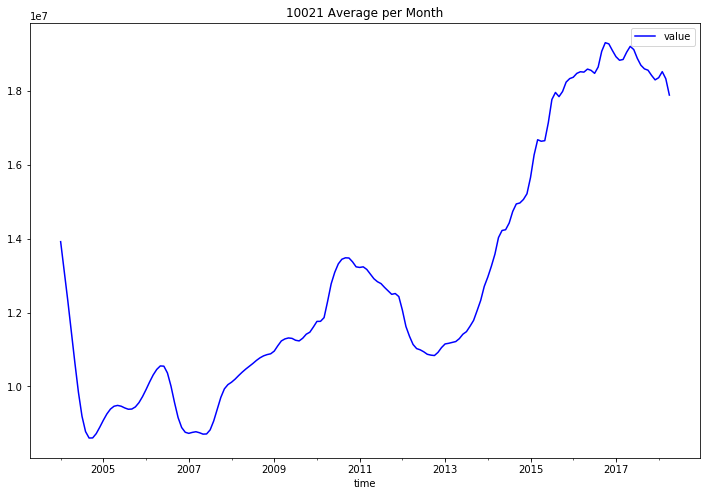

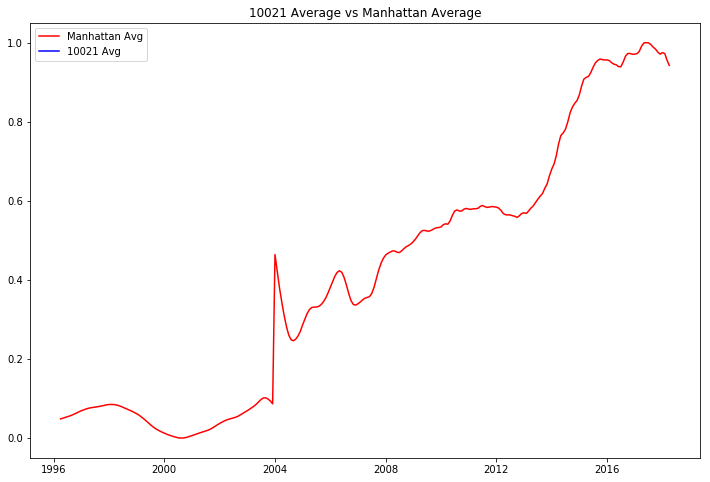

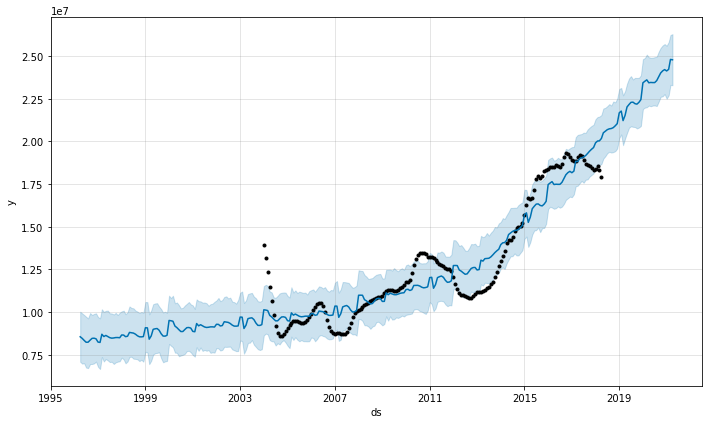

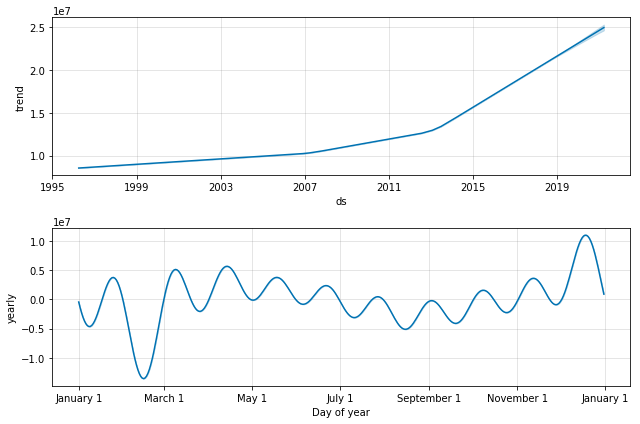

2018-04-01: 17894900.0
--------------------------------------------------------------
            ds          yhat    yhat_lower    yhat_upper
276 2019-04-01  2.152245e+07  2.016085e+07  2.294111e+07
288 2020-04-01  2.343463e+07  2.209812e+07  2.493029e+07
300 2021-04-01  2.478096e+07  2.329021e+07  2.628344e+07
--------------------------------------------------------------
% Increase 2019-04-01: [1.2027144]
% Increase 2020-04-01: [1.30957033]
% Increase 2021-04-01: [1.38480592]


In [38]:
nyc_check(10021)

Again, looking for highest % increase from 2018 Zillow's data to 2021 predicted data.

#### Code below combines all future predicted values and % increases.

In [39]:
manhattan_predictions = pd.DataFrame(columns = ('RegionName','ds',
                                                'yhat','yhat % increase',
                                                'yhat_lower','yhat_lower % increase',
                                                'yhat_upper','yhat_upper % increase'))

for x in newyorkcity_df['RegionName'].unique():
    zip_1 = newyorkcity_df[newyorkcity_df['RegionName'] == x].iloc[:,6:]
    zip_1 = zip_1.groupby('time').mean()
    zip_1.index = pd.to_datetime(zip_1.index)
    
    zip_prophet = zip_1.reset_index().rename(columns={'time': 'ds',
                                                      'value': 'y'})
    
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_important = forecast_important[(forecast_important['ds'] == '2019-04-01') |
                                        (forecast_important['ds'] == '2020-04-01') |
                                        (forecast_important['ds'] == '2021-04-01')]

    zip_1 = zip_1.reset_index()
    
    zip_add = pd.DataFrame({
        'RegionName': x,
        'ds': forecast_important['ds'],
        'yhat': forecast_important['yhat'],
        'yhat % increase': round(forecast_important['yhat']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_lower': forecast_important['yhat_lower'],
        'yhat_lower % increase': round(forecast_important['yhat_lower']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_upper': forecast_important['yhat_upper'],
        'yhat_upper % increase': round(forecast_important['yhat_upper']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
    })

    manhattan_predictions = pd.concat([manhattan_predictions, zip_add])
    print(f"Added: {x}")

Added: 10011
Added: 10128
Added: 10021
Added: 10014
Added: 11106
Added: 11231


In [40]:
manhattan_predictions[manhattan_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,10021,2021-04-01,2.478096e+07,1.385,2.341337e+07,1.308,2.640070e+07,1.475
300,11106,2021-04-01,1.386306e+06,1.255,1.301726e+06,1.179,1.470235e+06,1.331
300,11231,2021-04-01,3.740218e+06,1.229,3.498002e+06,1.149,3.954384e+06,1.299
300,10011,2021-04-01,1.368319e+07,1.192,1.287852e+07,1.122,1.444165e+07,1.258
300,10128,2021-04-01,8.475612e+06,1.147,7.835221e+06,1.061,9.110881e+06,1.233
300,10014,2021-04-01,9.932398e+06,1.109,9.353098e+06,1.044,1.054412e+07,1.177


Top Manhattan Zip Codes <br><br>
1 - 10021<br>
2 - 11106<br>
3 - 11231<br>

### Brooklyn Zip Codes
- <i> note* Everything is the same as the Manhattan codes

In [41]:
brooklyn_df = df_melt[(df_melt["CountyName"] == "Kings") & (df_melt['Metro'] == 'New York')]
brooklyn_avg_df = brooklyn_df[['time','value']].groupby('time').mean()

In [42]:
brooklyn_city_df = brooklyn_df[['RegionName','time','value']].groupby(['RegionName','time']).mean()
brooklyn_city_df = brooklyn_city_df.reset_index()
brooklyn_city_df = brooklyn_city_df.set_index('time')
brooklyn_city_df.index = pd.to_datetime(brooklyn_city_df.index)
brooklyn_city_df = brooklyn_city_df.reset_index()

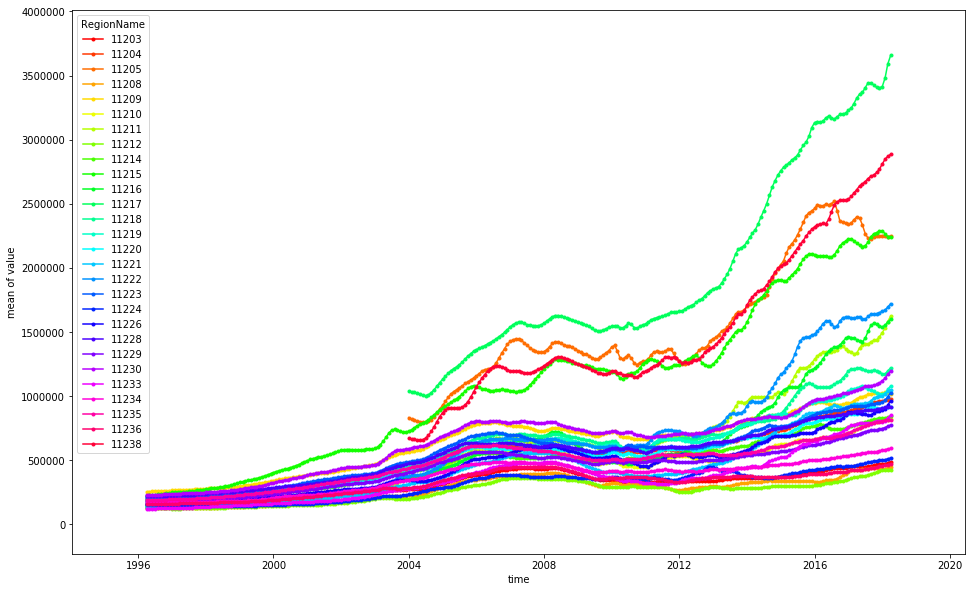

In [43]:
fig = interaction_plot(brooklyn_city_df['time'],brooklyn_city_df['RegionName'],brooklyn_city_df['value'])
fig.set_size_inches(16,10)
plt.show()

In [44]:
def brooklyn_check(zipcode):
    zip_df = brooklyn_df[brooklyn_df['RegionName'] == zipcode].iloc[:,6:]
    zip_df = zip_df.groupby('time').mean()
    zip_df.index = pd.to_datetime(zip_df.index)
    
    zip_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{zipcode} Average per Month")
    plt.show()
    
    brooklyn_avg_df = brooklyn_df[['time','value']].groupby('time').mean()
    brooklyn_avg_df.index = pd.to_datetime(brooklyn_avg_df.index)
    
    # No replacing NaN because it changes the predictions
    # zip_df = zip_df.fillna(method='bfill')
    
    zip_minmax = (zip_df['value'] - min(zip_df['value']))/(max(zip_df['value']) - min(zip_df['value']))
    brooklyn_minmax = (brooklyn_avg_df['value'] - min(brooklyn_avg_df['value']))/(max(brooklyn_avg_df['value']) - min(brooklyn_avg_df['value']))
    
    fig = plt.figure(figsize=(12,8))
    brooklyn = plt.plot(brooklyn_minmax, color='red', label='Brooklyn Avg')
    zipcode_plt = plt.plot(zip_minmax, color='blue', label=f"{zipcode} Avg")
    plt.legend(loc='best')
    plt.title(f'{zipcode} Average vs Brooklyn Average')
    plt.show()
    
    zip_prophet = zip_df.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    
    Model.plot(forecast, uncertainty=True)
    plt.show()
    
    Model.plot_components(forecast)
    plt.show()
    
    zip_df = zip_df.reset_index()
    
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    last_true = round(zip_df[zip_df['time'] == '2018-04-01']['value'].max(),0)
    first_predict = forecast_important[(forecast_important['ds'] == '2019-04-01')]['yhat'].values
    second_predict = forecast_important[(forecast_important['ds'] == '2020-04-01')]['yhat'].values
    third_predict = forecast_important[(forecast_important['ds'] == '2021-04-01')]['yhat'].values
    
    print(f"2018-04-01: {last_true}")
    print("--------------------------------------------------------------")
    print(forecast_important[(forecast_important['ds'] == '2019-04-01') |
                   (forecast_important['ds'] == '2020-04-01') |
                   (forecast_important['ds'] == '2021-04-01')])
    print("--------------------------------------------------------------")
    print(f"% Increase 2019-04-01: {first_predict/last_true}")
    print(f"% Increase 2020-04-01: {second_predict/last_true}")
    print(f"% Increase 2021-04-01: {third_predict/last_true}")

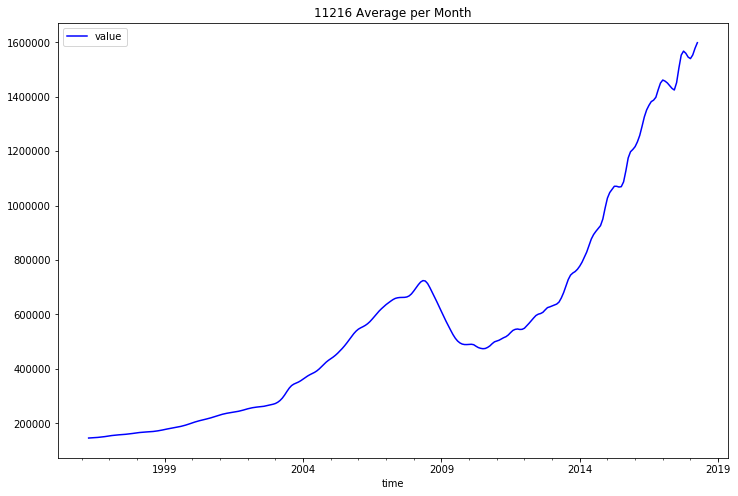

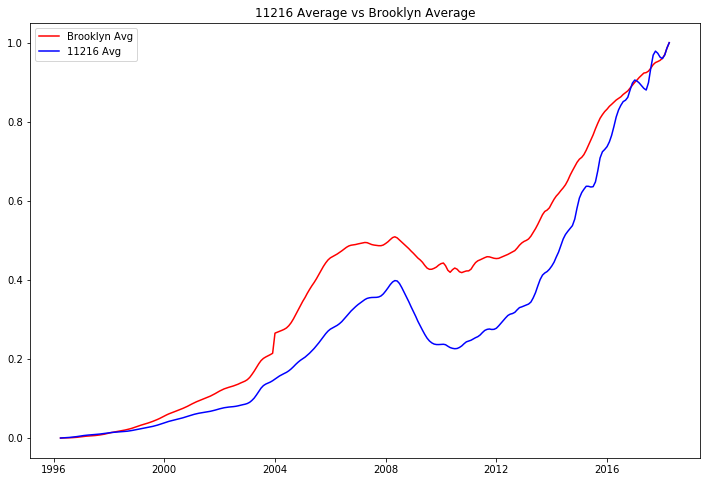

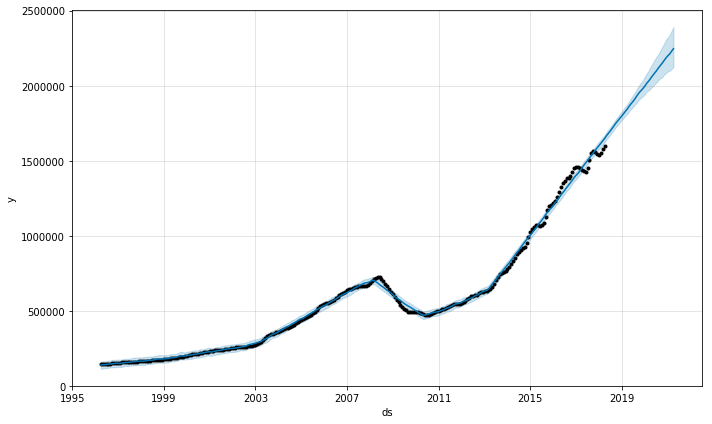

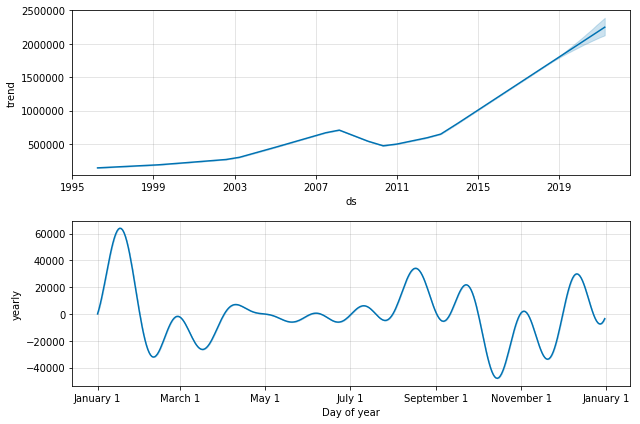

2018-04-01: 1598700.0
--------------------------------------------------------------
            ds          yhat    yhat_lower    yhat_upper
276 2019-04-01  1.847602e+06  1.815344e+06  1.878342e+06
288 2020-04-01  2.048357e+06  1.982283e+06  2.125598e+06
300 2021-04-01  2.246634e+06  2.125318e+06  2.391276e+06
--------------------------------------------------------------
% Increase 2019-04-01: [1.15569055]
% Increase 2020-04-01: [1.28126401]
% Increase 2021-04-01: [1.40528787]


In [45]:
brooklyn_check(11216)

In [46]:
brooklyn_predictions = pd.DataFrame(columns = ('RegionName','ds',
                                                'yhat','yhat % increase',
                                                'yhat_lower','yhat_lower % increase',
                                                'yhat_upper','yhat_upper % increase'))

for x in brooklyn_df['RegionName'].unique():
    zip_1 = brooklyn_df[brooklyn_df['RegionName'] == x].iloc[:,6:]
    zip_1 = zip_1.groupby('time').mean()
    zip_1.index = pd.to_datetime(zip_1.index)
    
    zip_prophet = zip_1.reset_index().rename(columns={'time': 'ds',
                                                      'value': 'y'})
    
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_important = forecast_important[(forecast_important['ds'] == '2019-04-01') |
                                        (forecast_important['ds'] == '2020-04-01') |
                                        (forecast_important['ds'] == '2021-04-01')]

    zip_1 = zip_1.reset_index()
    
    zip_add = pd.DataFrame({
        'RegionName': x,
        'ds': forecast_important['ds'],
        'yhat': forecast_important['yhat'],
        'yhat % increase': round(forecast_important['yhat']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_lower': forecast_important['yhat_lower'],
        'yhat_lower % increase': round(forecast_important['yhat_lower']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_upper': forecast_important['yhat_upper'],
        'yhat_upper % increase': round(forecast_important['yhat_upper']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
    })

    brooklyn_predictions = pd.concat([brooklyn_predictions, zip_add])
    print(f"Added: {x}")

Added: 11226
Added: 11235
Added: 11230
Added: 11209
Added: 11212
Added: 11214
Added: 11221
Added: 11229
Added: 11234
Added: 11215
Added: 11211
Added: 11238
Added: 11233
Added: 11236
Added: 11218
Added: 11223
Added: 11208
Added: 11204
Added: 11219
Added: 11203
Added: 11220
Added: 11216
Added: 11210
Added: 11224
Added: 11222
Added: 11205
Added: 11217
Added: 11228


In [47]:
brooklyn_predictions[brooklyn_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,11222,2021-04-01,2.423013e+06,1.408,2.331715e+06,1.355,2.526679e+06,1.468
300,11216,2021-04-01,2.246634e+06,1.405,2.114945e+06,1.323,2.380597e+06,1.489
300,11233,2021-04-01,1.152694e+06,1.352,1.081084e+06,1.268,1.232342e+06,1.446
300,11221,2021-04-01,1.409267e+06,1.344,1.328431e+06,1.267,1.491385e+06,1.422
300,11218,2021-04-01,1.630762e+06,1.336,1.566298e+06,1.283,1.714700e+06,1.404
300,11215,2021-04-01,2.993122e+06,1.334,2.889216e+06,1.288,3.093000e+06,1.378
300,11238,2021-04-01,3.676444e+06,1.274,3.486693e+06,1.208,3.857574e+06,1.337
300,11219,2021-04-01,1.334744e+06,1.236,1.283629e+06,1.189,1.393360e+06,1.291
300,11211,2021-04-01,2.001205e+06,1.232,1.921171e+06,1.183,2.091412e+06,1.288
300,11204,2021-04-01,1.197336e+06,1.226,1.134635e+06,1.162,1.265482e+06,1.296


Top Brooklyn Zip Codes <br><br>
1 - 11222<br>
2 - 11216<br>
3 - 11233<br>

## Queens Zip Codes vs Queens County
- <i> note* Everything is the same as the Manhattan codes

In [48]:
queens_df = df_melt[(df_melt["CountyName"] == "Queens") & (df_melt['Metro'] == 'New York')]
queens_avg_df = queens_df[['time','value']].groupby('time').mean()

In [49]:
queens_city_df = queens_df[['RegionName','time','value']].groupby(['RegionName','time']).mean()
queens_city_df = queens_city_df.reset_index()
queens_city_df = queens_city_df.set_index('time')
queens_city_df.index = pd.to_datetime(queens_city_df.index)
queens_city_df = queens_city_df.reset_index()

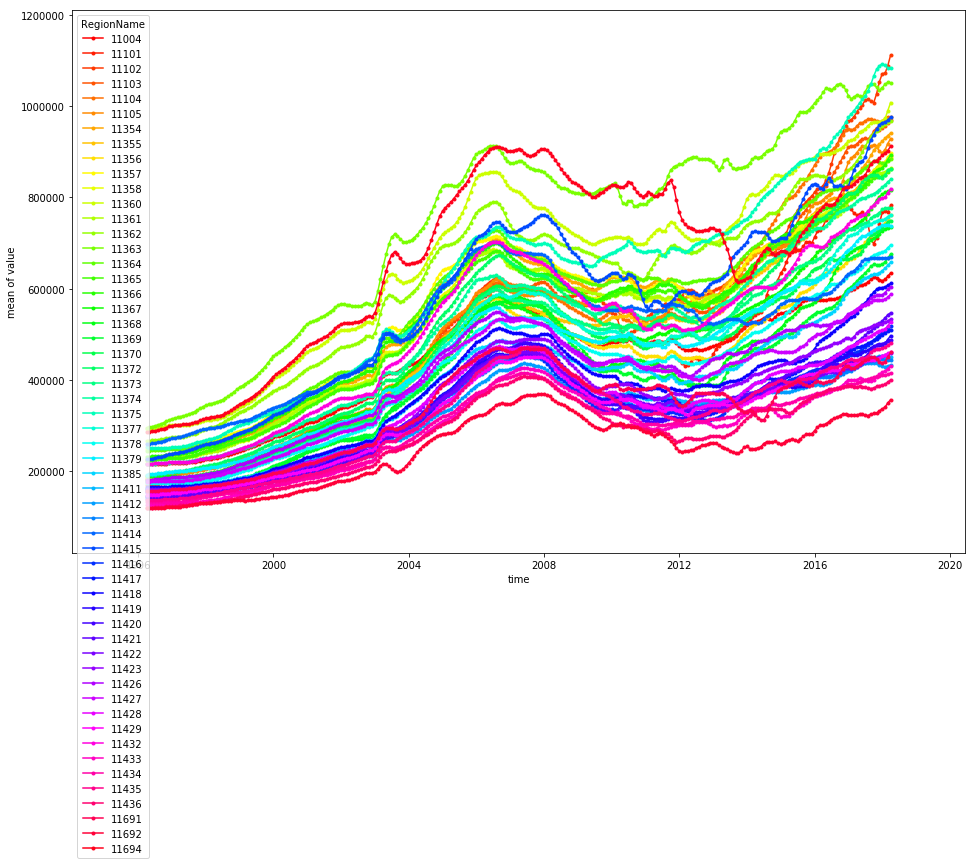

In [50]:
fig = interaction_plot(queens_city_df['time'],queens_city_df['RegionName'],queens_city_df['value'])
fig.set_size_inches(16,10)
plt.show()

This plot is way too congested and pointless but consistency amongst counties!

In [51]:
def queens_check(zipcode):
    zip_df = queens_df[queens_df['RegionName'] == zipcode].iloc[:,6:]
    zip_df = zip_df.groupby('time').mean()
    zip_df.index = pd.to_datetime(zip_df.index)
    
    zip_df.plot(kind = 'line', figsize= (12,8), color = 'blue')
    plt.title(f"{zipcode} Average per Month")
    plt.show()
    
    queens_avg_df = queens_df[['time','value']].groupby('time').mean()
    queens_avg_df.index = pd.to_datetime(queens_avg_df.index)
    
    # No replacing NaN because it changes the predictions
    # zip_df = zip_df.fillna(method='bfill')
    
    zip_minmax = (zip_df['value'] - min(zip_df['value']))/(max(zip_df['value']) - min(zip_df['value']))
    queens_minmax = (queens_avg_df['value'] - min(queens_avg_df['value']))/(max(queens_avg_df['value']) - min(queens_avg_df['value']))
    
    fig = plt.figure(figsize=(12,8))
    queens = plt.plot(queens_minmax, color='red', label='Queens Avg')
    zipcode_plt = plt.plot(zip_minmax, color='blue', label=f"{zipcode} Avg")
    plt.legend(loc='best')
    plt.title(f'{zipcode} Average vs Queens Average')
    plt.show()
    
    zip_prophet = zip_df.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    
    Model.plot(forecast, uncertainty=True)
    plt.show()
    
    Model.plot_components(forecast)
    plt.show()
    
    zip_df = zip_df.reset_index()
    
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    last_true = round(zip_df[zip_df['time'] == '2018-04-01']['value'].max(),0)
    first_predict = forecast_important[(forecast_important['ds'] == '2019-04-01')]['yhat'].values
    second_predict = forecast_important[(forecast_important['ds'] == '2020-04-01')]['yhat'].values
    third_predict = forecast_important[(forecast_important['ds'] == '2021-04-01')]['yhat'].values
    
    print(f"2018-04-01: {last_true}")
    print("--------------------------------------------------------------")
    print(forecast_important[(forecast_important['ds'] == '2019-04-01') |
                   (forecast_important['ds'] == '2020-04-01') |
                   (forecast_important['ds'] == '2021-04-01')])
    print("--------------------------------------------------------------")
    print(f"% Increase 2019-04-01: {first_predict/last_true}")
    print(f"% Increase 2020-04-01: {second_predict/last_true}")
    print(f"% Increase 2021-04-01: {third_predict/last_true}")

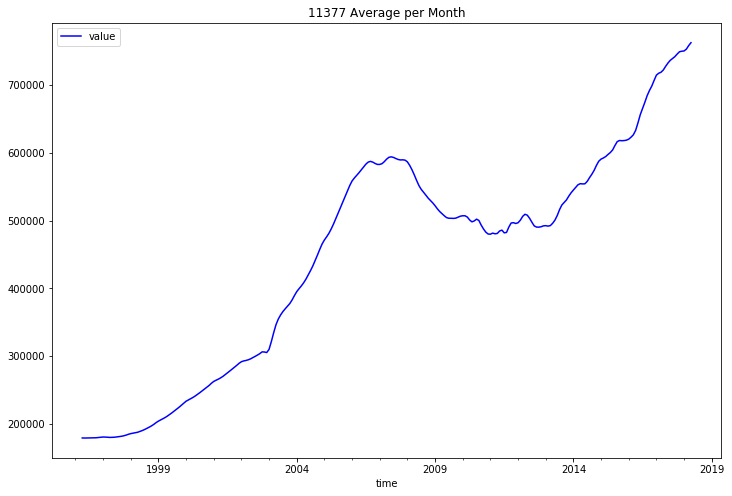

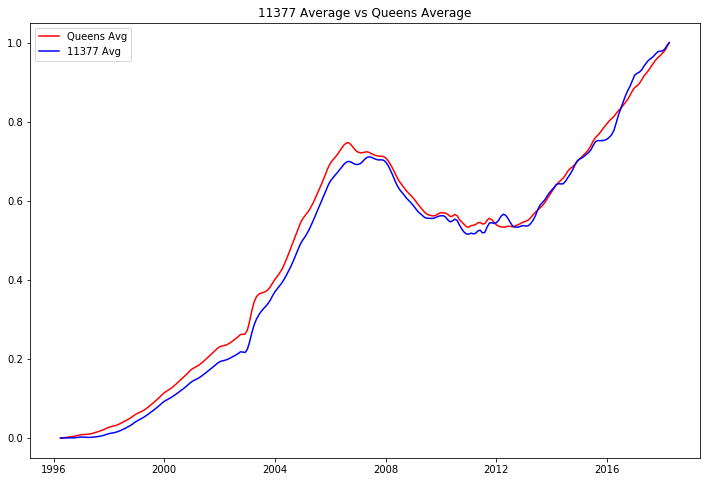

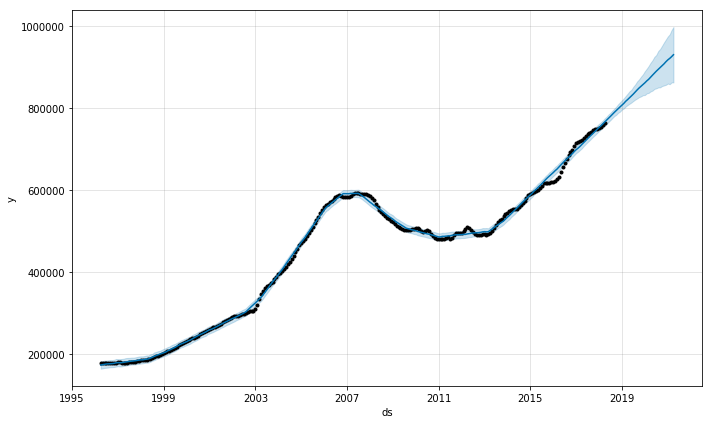

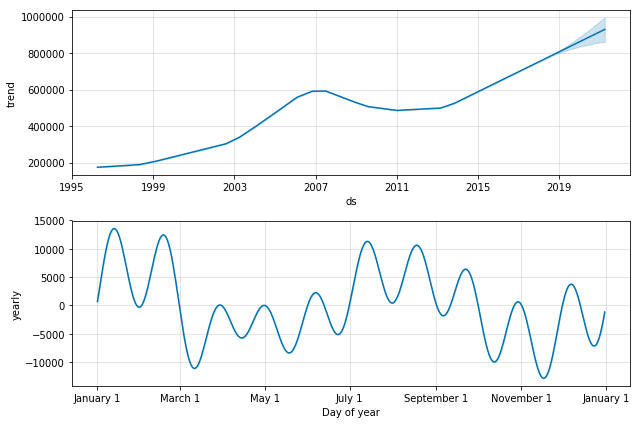

2018-04-01: 762500.0
--------------------------------------------------------------
            ds           yhat     yhat_lower     yhat_upper
276 2019-04-01  820467.311323  807167.792913  834887.990967
288 2020-04-01  875043.906073  840274.929334  910117.617720
300 2021-04-01  929728.152738  862355.723252  997262.393089
--------------------------------------------------------------
% Increase 2019-04-01: [1.0760227]
% Increase 2020-04-01: [1.14759857]
% Increase 2021-04-01: [1.21931561]


In [52]:
queens_check(11377)

In [53]:
queens_predictions = pd.DataFrame(columns = ('RegionName','ds',
                                                'yhat','yhat % increase',
                                                'yhat_lower','yhat_lower % increase',
                                                'yhat_upper','yhat_upper % increase'))

for x in queens_df['RegionName'].unique():
    zip_1 = queens_df[queens_df['RegionName'] == x].iloc[:,6:]
    zip_1 = zip_1.groupby('time').mean()
    zip_1.index = pd.to_datetime(zip_1.index)
    
    zip_prophet = zip_1.reset_index().rename(columns={'time': 'ds',
                                                      'value': 'y'})
    
    Model = proph(interval_width=0.80, weekly_seasonality=False, daily_seasonality=False)
    Model.fit(zip_prophet)
    future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
    forecast = Model.predict(future_dates)
    forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_important = forecast_important[(forecast_important['ds'] == '2019-04-01') |
                                        (forecast_important['ds'] == '2020-04-01') |
                                        (forecast_important['ds'] == '2021-04-01')]

    zip_1 = zip_1.reset_index()
    
    zip_add = pd.DataFrame({
        'RegionName': x,
        'ds': forecast_important['ds'],
        'yhat': forecast_important['yhat'],
        'yhat % increase': round(forecast_important['yhat']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_lower': forecast_important['yhat_lower'],
        'yhat_lower % increase': round(forecast_important['yhat_lower']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
        'yhat_upper': forecast_important['yhat_upper'],
        'yhat_upper % increase': round(forecast_important['yhat_upper']/zip_1[zip_1['time'] =='2018-04']['value'].max(),3),
    })

    queens_predictions = pd.concat([queens_predictions, zip_add])
    print(f"Added: {x}")

Added: 11375
Added: 11377
Added: 11355
Added: 11385
Added: 11373
Added: 11372
Added: 11368
Added: 11354
Added: 11374
Added: 11434
Added: 11691
Added: 11432
Added: 11101
Added: 11435
Added: 11365
Added: 11103
Added: 11367
Added: 11102
Added: 11357
Added: 11105
Added: 11364
Added: 11358
Added: 11104
Added: 11379
Added: 11413
Added: 11420
Added: 11414
Added: 11361
Added: 11412
Added: 11378
Added: 11421
Added: 11419
Added: 11433
Added: 11360
Added: 11415
Added: 11418
Added: 11423
Added: 11369
Added: 11422
Added: 11694
Added: 11417
Added: 11427
Added: 11692
Added: 11370
Added: 11356
Added: 11429
Added: 11362
Added: 11411
Added: 11426
Added: 11428
Added: 11004
Added: 11416
Added: 11436
Added: 11366
Added: 11363


In [54]:
queens_predictions[queens_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,11104,2021-04-01,1.297796e+06,1.329,1.241889e+06,1.272,1.352960e+06,1.386
300,11103,2021-04-01,1.244427e+06,1.284,1.188858e+06,1.227,1.309391e+06,1.351
300,11372,2021-04-01,1.101396e+06,1.278,1.021424e+06,1.185,1.176763e+06,1.365
300,11368,2021-04-01,9.332919e+05,1.269,8.625917e+05,1.173,1.006502e+06,1.369
300,11102,2021-04-01,1.394517e+06,1.254,1.331424e+06,1.197,1.458221e+06,1.311
300,11105,2021-04-01,1.157172e+06,1.245,1.105461e+06,1.190,1.214269e+06,1.307
300,11355,2021-04-01,1.093334e+06,1.228,1.026140e+06,1.153,1.153137e+06,1.295
300,11367,2021-04-01,9.968677e+05,1.222,9.355791e+05,1.147,1.054932e+06,1.293
300,11377,2021-04-01,9.297282e+05,1.219,8.692523e+05,1.140,9.919120e+05,1.301
300,11369,2021-04-01,8.218603e+05,1.216,7.454245e+05,1.103,8.891317e+05,1.316


Top Queens Zip Codes <br><br>
1 - 11104<br>
2 - 11103<br>
3 - 11372<br>

## Step 7 - Intepreting it all
Below dataframes tell it all.
- National Average % Increase
- Top 3 Zip Codes in Manhattan
- Top 3 Zip Codes in Brooklyn
- Top 3 Zip Codes in Queens
- top 5 Zip Codes in Manhattan, Brooklyn, and Queens

## National Average % Increase
It is important for us to compare the percent increase of the top zip codes to the national average. While making money is always good, if the zip codes are making less than the national average, it would not be considered the best zip code to invest in.

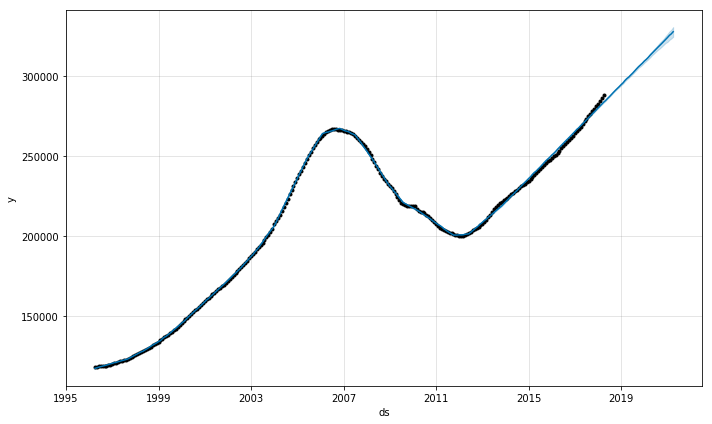

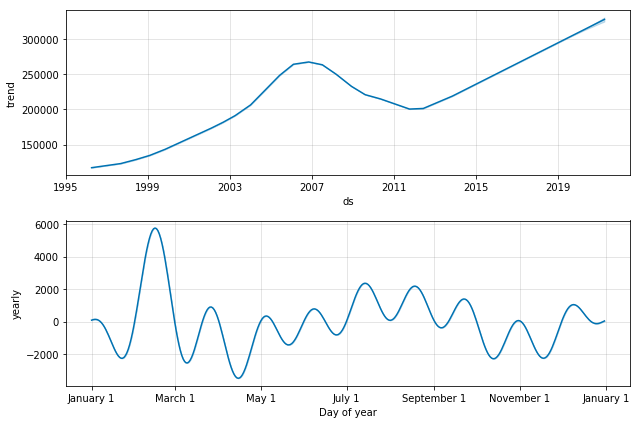

2018-04-01: 288040.0
--------------------------------------------------------------
            ds           yhat     yhat_lower     yhat_upper
276 2019-04-01  298567.019835  297955.232255  298909.237651
288 2020-04-01  313078.284940  311716.913649  314189.434265
300 2021-04-01  327821.056075  324650.968684  330773.505245
--------------------------------------------------------------
% Increase 2019-04-01: [1.03654708]
% Increase 2020-04-01: [1.08692642]
% Increase 2021-04-01: [1.13810949]


In [63]:
avg_prophet = avg_df.reset_index().rename(columns={'time': 'ds',
                                                        'value': 'y'})
Model = proph(interval_width=0.20, weekly_seasonality=False, daily_seasonality=False)
Model.fit(avg_prophet)
future_dates = Model.make_future_dataframe(periods = 36, freq = 'MS')
forecast = Model.predict(future_dates)
    
Model.plot(forecast, uncertainty=True)
plt.show()
    
Model.plot_components(forecast)
plt.show()

avg_df = avg_df.reset_index()
    
forecast_important = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
last_true = round(avg_df[avg_df['time'] == '2018-04-01']['value'].max(),0)
first_predict = forecast_important[(forecast_important['ds'] == '2019-04-01')]['yhat'].values
second_predict = forecast_important[(forecast_important['ds'] == '2020-04-01')]['yhat'].values
third_predict = forecast_important[(forecast_important['ds'] == '2021-04-01')]['yhat'].values
    
print(f"2018-04-01: {last_true}")
print("--------------------------------------------------------------")
print(forecast_important[(forecast_important['ds'] == '2019-04-01') |
                         (forecast_important['ds'] == '2020-04-01') |
                         (forecast_important['ds'] == '2021-04-01')])
print("--------------------------------------------------------------")
print(f"% Increase 2019-04-01: {first_predict/last_true}")
print(f"% Increase 2020-04-01: {second_predict/last_true}")
print(f"% Increase 2021-04-01: {third_predict/last_true}")

<b> National Average - 13.8% Increase by 2021

### Top 3 Zipcodes in Manhattan

In [55]:
manhattan_predictions[manhattan_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False).head(3)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,10021,2021-04-01,2.478096e+07,1.385,2.341337e+07,1.308,2.640070e+07,1.475
300,11106,2021-04-01,1.386306e+06,1.255,1.301726e+06,1.179,1.470235e+06,1.331
300,11231,2021-04-01,3.740218e+06,1.229,3.498002e+06,1.149,3.954384e+06,1.299


<b> Manhattan Zip 10021 - 38.5% increase by 2021

### Top 3 Zipcodes in Brooklyn

In [56]:
brooklyn_predictions[brooklyn_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False).head(3)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,11222,2021-04-01,2.423013e+06,1.408,2.331715e+06,1.355,2.526679e+06,1.468
300,11216,2021-04-01,2.246634e+06,1.405,2.114945e+06,1.323,2.380597e+06,1.489
300,11233,2021-04-01,1.152694e+06,1.352,1.081084e+06,1.268,1.232342e+06,1.446


<b> Brooklyn Zip 11222 - 40.8% increase by 2021

### Top 3 Zipcodes in Queens

In [57]:
queens_predictions[queens_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False).head(3)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,11104,2021-04-01,1.297796e+06,1.329,1.241889e+06,1.272,1.352960e+06,1.386
300,11103,2021-04-01,1.244427e+06,1.284,1.188858e+06,1.227,1.309391e+06,1.351
300,11372,2021-04-01,1.101396e+06,1.278,1.021424e+06,1.185,1.176763e+06,1.365


<b> Queens Zip 11104 - 32.9% increase by 2021

## Top 5 Zipcodes in New York City

In [58]:
all_predictions = pd.concat([queens_predictions, brooklyn_predictions, manhattan_predictions])
all_predictions[all_predictions['ds']=='2021-04-1'].sort_values(by=['yhat % increase'], ascending = False).head(5)

,RegionName,ds,yhat,yhat % increase,yhat_lower,yhat_lower % increase,yhat_upper,yhat_upper % increase
300,11222,2021-04-01,2.423013e+06,1.408,2.331715e+06,1.355,2.526679e+06,1.468
300,11216,2021-04-01,2.246634e+06,1.405,2.114945e+06,1.323,2.380597e+06,1.489
300,10021,2021-04-01,2.478096e+07,1.385,2.341337e+07,1.308,2.640070e+07,1.475
300,11233,2021-04-01,1.152694e+06,1.352,1.081084e+06,1.268,1.232342e+06,1.446
300,11221,2021-04-01,1.409267e+06,1.344,1.328431e+06,1.267,1.491385e+06,1.422


# Conclusion
<b> 
- Amongst the top 5 Zipcodes in New York City, 4 belong in Brooklyn, 1 in Manhattan.
- Housing price in 10021 is astronomically high. Despite it being 3rd best zip code to invest in, it may be a good idea to avoid.
- National housing price average will increase roughly 14% by 2021.
- According to the model, investing in the top 5 zip codes in 2018 will result in a 30% - 45% increase in house value by 2021.

The main focus of this project was New York City. However, in the future, we can expand the predictions to anywhere in the nation. There is a strong possibility that there are areas with preedictions stronger than 45% increases.<br>
A strong suggestion would be San Antonio, Texas.<br>
With more time, we can process all 14,723 zip codes in the nation, beyond NYC, to find the best areas to invest in.